In [1]:
import utlt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks, hilbert, windows, blackman, stft
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq, eigh, norm
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares
from scipy.constants import hbar, elementary_charge, speed_of_light, Boltzmann

from itertools import product
import copy
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D    # class for the split operator propagation
from numba import njit

from collections import Counter
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


from sklearn import linear_model

import glob
import os

from datetime import datetime

threads = 16
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [7]:
"""
Call an instance of BEC to get physical params. This way wavelengths may be set precisely for dimensionless units
"""
# Frequency of targeted atomic transition goes here.
# D1 transition (in nm)
#principal_wavelength = 794.978851e-9
# D2 transition (in nm)
principal_wavelength = 780.251210e-9
# Resonance frequency of the atomic transition in units of 2π Hz to keep units consistent
ω_0 = 2 * np.pi * speed_of_light / principal_wavelength

# Moddel parameters for dimensionless units.
ω_x = 0.5 * 2 * np.pi 
ω_yz = 200 * 2 * np.pi
N = 2e3
print(f'Resonance Frequency is: 2π * {(ω_0/(2*np.pi)) * 1e-12} THz')

atom_params = dict(
    atom='R87',
    kicked=False,
    omega_x=ω_x,
    omega_y=ω_yz,
    omega_z=ω_yz,
    number_of_atoms=N,
)
gpe = utlt.BEC(**atom_params)
g = gpe.g

"""
Define default params and use the default utility for saving
"""
# Number of pulses
n = 5
# Determine the error tolerance
eps = 1e-11
# Now declare the pulse parameters, starting with the wavelength closest to the transition
# For near resonance, this method is best
# λ_spacing = gpe.dimless_x((1 + 0.002) * principal_wavelength)
# λ_min = gpe.dimless_x(principal_wavelength + λ_spacing)
# For far-off-resonance wavelengths
λ_min = gpe.dimless_x(775e-9) #FLAG for theory
#λ_min = 1
λ_spacing = 0.2 #FLAG for theory
#λ_spacing =0.1
# Maximum wave_vector
k_max = 2 * np.pi / λ_min
#λ_array = [λ_min * (1 + _ * λ_spacing) for _ in range(0, n)]
#λ_array = gpe.dimless_x([775e-9, 776e-9, 777e-9, 778e-9, 779e-9]) 
#λ_array = gpe.dimless_x([775e-9, 779e-9])  
λ_array = gpe.dimless_x([779.2e-9, 779.4e-9, 778.6e-9, 779.8e-9, 780e-9]) 
ampl = np.sqrt(gpe.dimless_energy(600, -9)) #FLAG for theory
#ampl = 1

λ = gpe.dimless_x((1 / 3) * principal_wavelength) #FLAG
#λ = 0.25
print(f'Target λ is {λ} in dimensionless units')
k = 2 * np.pi / λ
x_win = np.pi / (k)
x_lim = gpe.dimless_x(gpe.L_x) / 2 #FLAG for theory
#x_lim = 20 * λ
x_res = 2 ** 20
dx = 2 * x_win / x_res
dx_zoom = 2. * x_lim / x_res
x = np.arange(-x_win, x_win, dx)
x_units = gpe.convert_x(x, -6)
zoom_out_x = np.arange(-x_lim, x_lim, dx)
# Get the length of the x window
x_length = zoom_out_x[-1] - zoom_out_x[0]

print(f'The wavelengths are : {[np.round(gpe.convert_x(_, -9), 2) for _ in λ_array]} nm')
print(f' the dx for this run is {gpe.convert_x(dx, -9)} nm, or {dx} in dimensionless units')

Resonance Frequency is: 2π * 384.225559868084 THz
Target λ is 0.017053260602803832 in dimensionless units
The wavelengths are : [779.2, 779.4, 778.6, 779.8, 780.0] nm
 the dx for this run is 0.00024803517977396646 nm, or 1.626325664787658e-08 in dimensionless units


In [8]:
############################################################
#
# It is important to calculate the Critical Temp for a BEC
# This ensures that simulations are actually a BEC, and not
# just wishful thinking. 
#
# T_c = (number density / ζ(3/2))^(2/3) * 2πħ^2 / m*kB
#
############################################################

# The volume in micrometers temporarily to avoid machine precision
# These changes to order of magitude are corrected for by removing orders of known quantities
# ħ = 1.054571817e-34, kB=1.380649e-23*1e-9nK/K, m_87Rb=1.4431609e-25, L_i∝1e-6, Volume∝1e-18
# (N/∝1e-18)^(2/3) → (N/orderless_volume)^(2/3)*1e12, 
# simply multiplying by orders, we get 1e12 * ((1e-34)^2 / (1e-23*1e-9*1e-25)) → 1e12 * 1e57 / 1e68 → 1e1, 10
volume = (gpe.L_x * 1e6) * (gpe.L_y * 1e6) * (gpe.L_z * 1e6)
number_density = N / volume 
ζ_32 = 2.61237534869    # Riemman Zeta function (3/2)
T_c = 10 * (number_density / ζ_32) ** (1.5) * 2 * np.pi * 1.054571817 ** 2 / (1.4431609 * 1.380649)


# Now print the parameters for the run so that simulations can guarantee T << T_c
print(f'T_c, the critical temperature, is {T_c} nK.\nThis will be checked when modeling experiment')
print(f'The wavelength spacing is {λ_spacing * gpe.convert_x(λ_min, -9)} nm')
print(f'The conversion factor for dimensionless energy {gpe.dimless_energy(1, -9)}')
print(f'The target potential amplitude is {round(gpe.convert_energy(ampl ** 2, -9), 2)} nK, or ~{round(ampl ** 2, 2)} in dimensionless units.')
print(f'The characteristic length, L_x is {gpe.L_x *1e6} μm')
print(f'The transverse characteristic length, L_y, L_z is {gpe.L_y *1e6} μm')
print(f'The shortest wavelength for this for this run is {gpe.convert_x(λ_min, -9)} nm')

T_c, the critical temperature, is 28128.06233618118 nK.
This will be checked when modeling experiment
The wavelength spacing is 155.0 nm
The conversion factor for dimensionless energy 41.67323824665515
The target potential amplitude is 600.0 nK, or ~25003.94 in dimensionless units.
The characteristic length, L_x is 15.25126148743101 μm
The transverse characteristic length, L_y, L_z is 0.7625630743715506 μm
The shortest wavelength for this for this run is 775.0 nm


In [9]:
named_params = {
    'tgt_wavelength': round(λ, 2),
    'shortest_wlen':round(λ_min, 6),
    'tgt_amplitutde':round(ampl, 2),
    'pulses': n,
    'min_wlen': round(λ_min, 2),
    'wlen_spacing': round(λ_spacing, 6),
}
params = copy.deepcopy(named_params)
file_path, file_name= utlt.build_saves_tag(params_list=named_params, unique_identifier='D2-ExpDemo-Blue', parent_directory='Archive_Data/Superoscilations')
ok = utlt.standardize_plots(plt.rcParams)

def get_wide_plot(params=plt.rcParams):
    wide_plt_params = {
        'figure.figsize': (4, 3),
        'figure.dpi': 300,
        'legend.fontsize': 7,
        'axes.labelsize': 10,
        'axes.titlesize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'lines.linewidth': 2,
    }
    params.update(wide_plt_params)

Parent directory check passed! 
Results will be available in Archive_Data/Superoscilations

You may be overwriting previous data (; n;)



In [10]:
# Get the contant prefactor for α in dimensionless units.
# (elementary_charge^2 order e-38) / (mass order e-25, hbar order e-34)
# comes out to 1e-38 / 1e-59, or 1e21 after everything, round to 8 digits because of precision
α_dimless = round(1e21 * (1.602176634 ** 2 * 1.380649)/ (1.44316060 * 1.054571817 * ω_x), 8) 

In [11]:
def Phi(grid, wave_vector, phase=0, amplitude=1):
    return amplitude * np.sin(wave_vector * grid + phase)

def Phi_transform(time, frequency, amplitude_1, amplitude_2):
    return amplitude_1 * np.sin(frequency * time) + amplitude_2 * np.cos(frequency * time)

def Phi_combine(A, B, wave_vector, grid):
    amplitude = np.sqrt(A ** 2 + B ** 2)
    phase = np.angle(A + 1j * B)
    single_field = amplitude * np.cos(wave_vector * grid - phase)
    return amplitude, phase, single_field

def field_to_V_scaling(wavelength):
    # It is important to pass the wavelength in meters!
    frequency = 2 * np.pi * speed_of_light / wavelength
    α = 1.602176634 ** 2 / 1.4431606 # the order of magnitude, 10^-13, will be added in the next line.
    return (0.5 * α / (ω_0 ** 2 - frequency ** 2)) * 1e-13
    
    

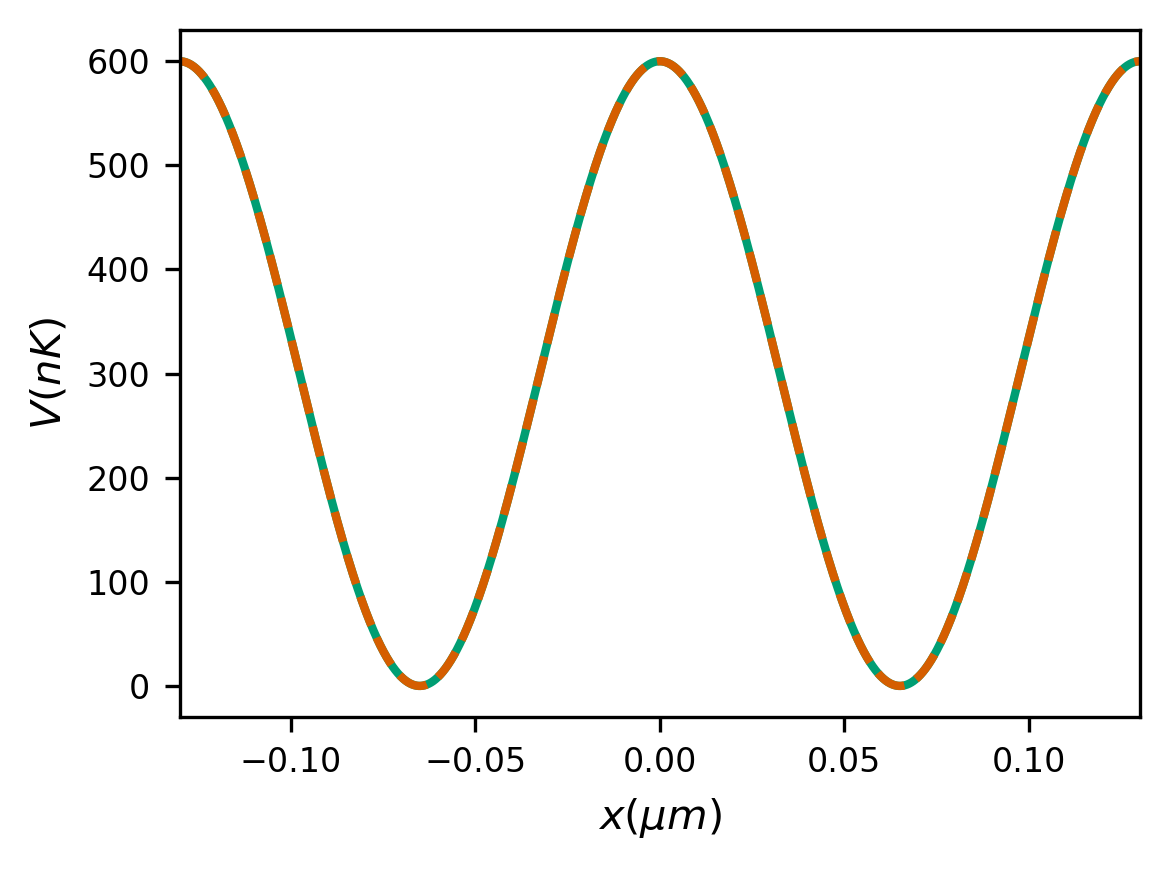

In [12]:
# This was used as a demonstration to show that Okabe Ito color scheme produces colors which colorblind people can see
# In general, NEVER DO THIS, even if you are using a colorblind friendly system.
target_barrier = Phi(x, k, amplitude = ampl, phase=-np.pi/2)
plt.plot(x_units , gpe.convert_energy(target_barrier  ** 2 , -9), color=ok['green']) #FLAG
plt.plot(x_units, gpe.convert_energy(target_barrier  ** 2, -9), color=ok['red'], linestyle='--')
plt.xlabel('$x (\mu m)$')
plt.ylabel('$V (nK)$')
plt.xlim(x_units[0], x_units[-1])

plt.tight_layout()
#plt.savefig(f'{file_path}/{file_name}_Init_Potential.pdf')
plt.show()

In [13]:
##############################################
#
# Get the initial guesses for the optimization
#
##############################################

# New array for time
# Set
workers = 64
# Number of initial guesses per thread
init_guess_n = workers * 20


seed = np.random.default_rng(2024)
# Create the array of variables for the initial guess
initial_guess = np.hstack([
    # Phase
    seed.uniform(-2*np.pi, 2*np.pi, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, ampl*1e3, (init_guess_n, n))
])

freqs = 2 * np.pi * (np.array(λ_array) ** (-1))

print('Number of Pulses: {}'.format(n))
#initial_guess = np.array([20, 0, 0, 1])

print('Length of x: ' + str(len(initial_guess)))

print(f'Frequencies are: {freqs}')
print(f'Wavelengths are: {λ_array}')

# Define the constraints
phase_lims = (-2 * np.pi, 2 * np.pi)           # Time delay constrained to be positive
ampl_lims = (0, None)      # Some constraints for amplitude


# Create the array of bounds for the best fit minimization
bnds = np.concatenate([
    # Phase limits
    np.full((n, 2), phase_lims),
    # Amplitude limits
    np.full((n, 2), ampl_lims)
])

initial_guess_alt = np.hstack([
    # Phase
    seed.uniform(1, 20, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 20, (init_guess_n, n))
])

# Define the constraints
ai_lims = (0, None)
bi_lims = (0, None)


# Create the array of bounds for the best fit minimization
bnds_alt = np.concatenate([
    # Phase limits
    np.full((n, 2), ai_lims),
    # Amplitude limits
    np.full((n, 2), bi_lims)
])


Number of Pulses: 5
Length of x: 1280
Frequencies are: [122.98062384 122.94906607 123.07539442 122.88599909 122.85448986]
Wavelengths are: [0.05109086 0.05110397 0.05105151 0.0511302  0.05114331]


In [14]:
#######################################
#
# Define Functions for fitting
#
#######################################


def unpack(f):
    # Ensure that the array is equally divisible by number of parameters
    length, res = divmod(len(f), 2)
    assert res == 0
    phases = f[:length]
    amplitudes = f[length:(2 * length)]
    
    return phases, amplitudes

def phi_func(f, t):
    phase, amplitude = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi(t, i, j, k) for i, j, k in zip(freqs, phase, amplitude))

def obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x



def phi_func_alt(f, t):
    ai, bi = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi_transform(t, i, j, k) for i, j, k in zip(freqs, ai, bi))

def obj_alt(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func_alt(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds_alt,
        tol=eps
    )
    return result.fun, result.x



In [15]:
def super_obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x)) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x

In [ ]:
#########################################################################
#
# Fitting the fields by optimizing the frequencies, delays, and streches
# Uses Parallel computing to find best results
#
#########################################################################

if __name__ == '__main__':
    with Pool(processes=workers) as pool:
        result = pool.map(obj, initial_guess)
        #result_super = pool.map(super_obj, initial_guess)
        #result_alt = pool.map(obj_alt, initial_guess_alt)

In [ ]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result.sort(key=lambda _: _[0])
opt_vals = result[0][1]
best_fit = phi_func(opt_vals, x)
best_fit_phases, best_fit_amps = unpack(opt_vals)
print(f'Amplitudes here are: {best_fit_amps}')
print(f'Prefactors for each field are: {field_to_V_scaling(gpe.convert_x(λ_array, 0))}')

plt.plot(x, best_fit ** 2 , label='Superoscillating Trap')
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl)) ** 2, label='Highest $k$ Component')
plt.plot(x, target_barrier ** 2 , linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
#plt.ylim(0, 1.1*ampl**2)
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results.pdf')
#plt.savefig('./Plots/Presentation/Results.pdf')
plt.show()

In [ ]:
############################################################
#
# Show the complete potential
#
############################################################

best_fit_zoom = phi_func(opt_vals, zoom_out_x)
c1 = ok['blue']
c2 = ok['orange']

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(zoom_out_x, best_fit_zoom ** 2, label='Superoscillating Trap', color=c1)

ax2=ax1.twinx()
ax2.plot(zoom_out_x, Phi(zoom_out_x, k/2, amplitude=ampl) ** 2, label='Highest Frequency Component', color=c2)

ax1.tick_params('y', labelcolor=c1)
ax2.tick_params('y', labelcolor=c2)
ax1.set_xlabel('$x {\\rm (arb. u.)}$')
ax1.set_ylabel('$V {\\rm (arb. u.)}$', color=c1)
ax2.set_ylabel('Highest freq component $V {\\rm (arb. u.)}$', color=c2)
ax1.set_xlim(-x_win, x_win)

ax1.set_zorder(1)
ax1.patch.set_visible(False)
#plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ResultsZoomed.pdf')
#plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
plt.show()

In [ ]:
#########################################################################
#
# Fitting the fields by linear model, as it can be convexly solved
#
#########################################################################
fields = np.array([
    Phi(x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

fields_zoomed = np.array([
    Phi(zoom_out_x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

#model = linear_model.Lasso(alpha=0.0001, fit_intercept=False, tol=1e-6, max_iter=100000)
#model = linear_model.Ridge(fit_intercept=False, tol=1e-6, max_iter=100000)
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(fields, target_barrier)

linear_optimized_fields = fields @ model.coef_
lo_fields_zoom = fields_zoomed @ model.coef_

In [ ]:
#print(λ)
#plt.plot(x, target_barrier, linestyle=(0, (5, 1)), label='Target field')
#plt.xlabel('$x$ (arb. u.)')
#plt.ylabel('$E$ (arb. u.)')
#plt.xlim(x[0], x[-1])
#plt.ylim(-0.025, 1.5*ampl**2)
#plt.legend(loc='upper center')
#plt.tight_layout()

#plt.show()

In [ ]:
############################################################################
#
# Plot the results for linear optimization
#
############################################################################
plt.plot(x, np.abs(linear_optimized_fields) ** 2, label='Superoscillating Potential')
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl, phase=0)) ** 2, label='Highest $k$ Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential')
plt.xlabel('$x$ (arb. u.)')
plt.ylabel('$V$ (arb. u.)')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.5*ampl**2)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linear.pdf')

plt.show()



In [ ]:
############################################################################
#
# Get the amplitudes of the fields used to see if they are realistic
#
############################################################################

single_func_amps = [np.sqrt((model.coef_[_]) ** 2 + (model.coef_[_+1]) ** 2) for _ in np.arange(0, len(model.coef_), 2)]
single_func_phase = [np.pi/2-np.angle(model.coef_[_ + 1] + 1j * model.coef_[_]) for _ in np.arange(0, len(model.coef_), 2)]
simplified_fields = [Phi(zoom_out_x, freqs[_], phase=single_func_phase[_], amplitude= single_func_amps[_]) for _ in range(len(freqs))]
print(f'Individual amplitudes are {model.coef_}')
print(f'Dimensionless amplitudes are {single_func_amps}')
print(f'Phases are {single_func_phase}')

#plt.plot(zoom_out_x, lo_fields_zoom, label='Comparrison Field')
#plt.plot(zoom_out_x, np.sum(simplified_fields, axis=0), '--', label='Simplified Field')
#plt.xlabel('$x$')
#plt.ylabel('$ V(x)$')
#plt.xlim(zoom_out_x[0], zoom_out_x[-1])
#plt.legend(loc='upper center')
#plt.tight_layout()
#plt.show()


In [ ]:
############################################################################
#
# Plot the zoom out of the results for linear optimization
#
############################################################################

c1 = ok['blue']
c2 = ok['orange']

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(zoom_out_x, np.abs(lo_fields_zoom) ** 2, label='Superoscillating Potential', color=c1)

ax2=ax1.twinx()
ax2.plot(zoom_out_x, np.abs(Phi(zoom_out_x, k_max, amplitude=ampl)) ** 2, label='Highest $k$ Component', color=c2)

ax1.tick_params('y', labelcolor=c1)
ax2.tick_params('y', labelcolor=c2)
ax1.set_xlabel('$x$ (arb.u)')
ax1.set_ylabel('$V$ (arb.u)', color=c1)
ax2.set_ylabel('Highest $k$ Component $V$ (arb.u)', color=c2)
ax1.set_xlim(-x_lim, x_lim)

ax1.set_zorder(1)
ax1.patch.set_visible(False)

plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linearZoomed.pdf')
#plt.savefig('./Plots/Presentation/Results_linearZoomed.pdf')
plt.show()

In [ ]:
#########################################################################
#
# Plot the results on top of eachother
#
#########################################################################

c1=ok['blue']
c2=ok['orange']
c3=ok['green']
c4=ok['purple']

# Run a quick sweep to get smaller plots in an acceptable format
get_wide_plot(plt.rcParams)

plt.figure(layout='constrained')
plt.subplot(121)
plt.plot(x, best_fit ** 2 , label='Simple Fitting', color=c1)
plt.plot(x, np.abs(linear_optimized_fields) ** 2, label='Linear Regression', color=c2)
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential', color=c3)
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl, phase=0)) ** 2, label='Shortest $\lambda$ Component', color=c4, zorder=0)
plt.xlabel('$x$ (arb. u.)')
plt.ylabel('$V_{\\rm control}$ (arb. u.)')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.5*ampl**2)
plt.legend(loc='upper center')

plt.subplot(122)
plt.bar(np.arange(1, n+1, 1)+0.2, np.abs([opt_vals[_] for _ in np.arange(1, len(opt_vals-1), 2)]), width=0.4, color=c1, label='Simple Fitting')
plt.bar(np.arange(1, n+1, 1)-0.2, np.abs(single_func_amps), width=0.4, color=c2, label='Linear Regression')
plt.xticks(np.arange(1, n+1, 1))
plt.ticklabel_format(axis='y', style='sci', scilimits=[-5, 3])
plt.xlabel('$j$')
plt.ylabel('$a_j$')
plt.legend(loc='upper center')

#plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_combined.pdf')

plt.figure(layout='constrained')
plt.subplot(121)
plt.bar(np.arange(1, n+1, 1)+0.2, np.abs([opt_vals[_] for _ in np.arange(1, len(opt_vals-1), 2)]), width=0.4, color=c1, label='Simple Fitting')
plt.xticks(np.arange(1, n+1, 1))
plt.ticklabel_format(axis='y', style='sci', scilimits=[-5, 3])
plt.xlabel('$j$')
plt.ylabel('$a_j$')
plt.subplot(122)
plt.bar(np.arange(1, n+1, 1)-0.2, np.abs(single_func_amps), width=0.4, color=c2, label='Linear Regression')
plt.xticks(np.arange(1, n+1, 1))
plt.ticklabel_format(axis='y', style='sci', scilimits=[-5, 3])
plt.xlabel('$j$')
plt.ylabel('$a_j$')
plt.legend(loc='upper center')

# Now that the wide plot is done, return to standardized plotting
ok = utlt.standardize_plots(plt.rcParams)


In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(zoom_out_x, np.abs(lo_fields_zoom) ** 2, label='Linear Regression', color=c2)
ax1.plot(zoom_out_x, np.abs(best_fit_zoom) ** 2, label='Simple Fitting', color=c1)

ax2=ax1.twinx()
ax2.plot(zoom_out_x, np.abs(Phi(zoom_out_x, k_max, amplitude=ampl)) ** 2, label='Shortest $\lambda$ component $V$', color=c4)

#ax1.tick_params('y', labelcolor=c1)
ax1.set_ylim(0, 1.25 * max(np.abs(lo_fields_zoom) ** 2))
ax2.tick_params('y', labelcolor=c4)
ax2.set_ylim(0, 1.25 * ampl ** 2)
ax1.legend(loc='upper center')
ax1.set_xlabel('$x$ (arb.u)')
ax1.set_ylabel('$V_{\\rm control}$ (arb.u)')
ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=c4)
ax1.set_xlim(-x_lim, x_lim)

ax1.set_zorder(3)
ax1.patch.set_visible(False)

plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_combinedZoomed.pdf')
#plt.savefig('./Plots/Presentation/Results_linearZoomed.pdf')
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(zoom_out_x, np.abs(lo_fields_zoom) ** 2, label='Linear Regression', color=c2)

ax2=ax1.twinx()
ax2.plot(zoom_out_x, np.abs(best_fit_zoom) ** 2, label='Simple Fitting', color=c1)

#ax1.tick_params('y', labelcolor=c1)
ax1.set_ylim(0, 1.25 * max(np.abs(lo_fields_zoom) ** 2))
ax1.tick_params('y', labelcolor=c2)
ax2.tick_params('y', labelcolor=c1)
ax2.set_ylim(0, 1.25 * max(np.abs(best_fit_zoom) ** 2))
ax1.set_xlabel('$x$ (arb.u)')
ax1.set_ylabel('Linear Regression $V_{\\rm control}$ (arb.u)', color=c2)
ax2.set_ylabel('Somple Fitting $\lambda$ $V$ (arb.u)', color=c1)
ax1.set_xlim(-x_lim, x_lim)

ax1.set_zorder(3)
ax1.patch.set_visible(False)
plt.savefig(f'{file_path}/{file_name}_Results_combinedZoomed_onlyFits.pdf')

plt.tight_layout()
plt.show()

In [ ]:
#########################################################################
#
# Alternate option, generating best fields by solving eigenvalue problem
#
#########################################################################
# create the overlap matrix
S = fields.T @ fields
# Solve the eigenvalue problem
vals, vecs = eigh(S)

eig_fields = [fields @ vecs[:, _] for _ in range(len(vecs[:]))]
eig_fields_zoomout = [fields_zoomed @ vecs[:, _] for _ in range(len(vecs[:]))]


In [ ]:
largest_freq_pulse = Phi(x, k_max)
largest_freq_pulsez = Phi(zoom_out_x, k_max)


color1 = ok['blue']
color2 = ok['purple']

get_wide_plot(plt.rcParams)

for _ in range(n*2):
    #fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
    fig, (ax1, ax1__) = plt.subplots(1, 2, figsize=(4,2))
    eig_vector=vecs[:, _]
    single_field_eig_vectors = [np.sqrt((eig_vector[_]) ** 2 + (eig_vector[_+1]) ** 2) for _ in np.arange(0, len(eig_vector), 2)]
    

    ax1.set_ylabel('$V$ (arb. u.)', color=color1)
    ax1.plot(x, np.abs(eig_fields[_]) ** 2, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xticks([-0.008, 0, 0.008])
    ax1.set_xlim(x[0], x[-1])

    ax1.set_xlabel('$x {\\rm (arb. u.)}$')
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=color2)
    ax2.plot(x, largest_freq_pulse ** 2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)    
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)

    # plot zoom out view
    
    """ax1 = ax1_
    
    ax1.set_ylabel('$V$ (arb.u)', color=color1)
    ax1.plot(zoom_out_x, eig_fields_zoomout[_] ** 2, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('$x$ (arb.u)')

    ax2 = ax1.twinx() 

    ax2.plot(zoom_out_x, largest_freq_pulsez ** 2, color=color2)
    ax2.set_ylabel('Shortest $\lambda$ $V$ (arb. u.)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)"""
    
    # plot pulses
    ax1 = ax1__
    
    #ax1.bar(np.arange(eig_vector.size), eig_vector, color=ok['green'])
    ax1.bar(np.arange(1, n+1, 1), single_field_eig_vectors, color=ok['green'])
    #bar_width=0.75*(freqs[1]-freqs[0])
    #ax1.bar(freqs, single_field_eig_vectors, width=bar_width, color=ok['green'])
    #ax1.set_xticks(freqs)
    ax1.set_xticks(np.arange(1, n+1, 1))
    #ax1.set_xticklabels(λ_array, rotation='vertical')
    ax1.set_ylim(0,1)
    ax1.set_xlabel('$j$')
    ax1.set_ylabel('$a_{j}$ (arb. u.)')
    
    fig.tight_layout()
    plt.savefig(f'{file_path}/{file_name}_aBa_EigenvectorSolution{_}.pdf')

plt.show()

ok=utlt.standardize_plots(plt.rcParams)

In [ ]:
#########################################################################
#
# After visually assessing optimal field, declare it here 
#
#########################################################################

best_plot = 5
eig_winner = eig_fields[best_plot]
winner_zoom = eig_fields_zoomout[best_plot]
winner_amps = vecs[best_plot]
winner_combined_amps = np.array([np.sqrt(vecs[best_plot][_] ** 2 +vecs[best_plot][_+1] ** 2) for _ in np.arange(0, len(eig_vector), 2)])
# visual assesment modifier
vam = 10
print(f'The multiplier to achieve desired amplitude is: {vam}')
print(f'The six individual amplitudes are then {winner_amps * vam}')
print(f'The field amplitudes squared are then {gpe.convert_energy((vam * winner_combined_amps) ** 2, -9)} nK')

# The potential has been represented in units of nK, but for the α calculation, we need the field in units of Joules
converted_amplitudes = np.sqrt(gpe.convert_energy((vam * winner_combined_amps) ** 2, 0) * Boltzmann)
field_prefactors = [field_to_V_scaling(gpe.convert_x(_, 0)) for _ in λ_array]
print(f'The field amplitudes in "Joules" are {converted_amplitudes}')
print(f'The potential energy prefactors are {field_prefactors}')

fig=plt.figure(figsize=(8,3))
ax1=fig.add_subplot(121)
ax1.plot(gpe.convert_x(x, -9), gpe.convert_energy((vam * eig_winner) ** 2, -9), color=color1)
ax1.set_xlabel('$x (nm)$')
ax1.set_xlim(x_units[0]*1e3, x_units[-1]*1e3)
ax1.set_ylabel('$V_{control} (nK)$', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)


ax2 = ax1.twinx()

ax2.plot(gpe.convert_x(x, -9), largest_freq_pulse ** 2, color=color2)
ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)


ax3 = fig.add_subplot(122)
ax3.bar(np.arange(1, n+1, 1), (converted_amplitudes ** 2) * (np.abs(np.array(field_prefactors)) ** -1) * 1e-3, color=ok['green'])
ax3.set_xticks(np.arange(1, n+1, 1))
ax3.set_xlabel('$j$')
ax3.set_ylabel('$\\frac{\\alpha(\\omega)}{2} a_{j}^{2}$ (MJ)')
plt.tight_layout()
#plt.savefig(f'{file_path}/{file_name}_EigenvectorSolution_Scaled.pdf')
plt.show()   

adjusted_eig_winner = vam * eig_winner
adjusted_eig_zoom = vam * winner_zoom

In [ ]:
def get_local_freq(field, time):
    phase = np.unwrap(np.angle(hilbert(field)))
    return np.gradient(phase, np.pi / (time.max() - time.min()))


## Below is the BEC section. Please declare the field you wish to use.

In [ ]:
########################################################################################################################
# The field goes here
########################################################################################################################

pre_cooling = True
tags_opts = ['BestFit', 'SKLearnLinReg', f'EigenSolution_{best_plot}']
field_opts = [[best_fit, best_fit_zoom], [linear_optimized_fields, lo_fields_zoom], [adjusted_eig_winner, adjusted_eig_zoom]]

op = 2

test_field_so_window, test_field_full = field_opts[op]
test_field_tag = tags_opts[op]

# Coordinates are declared as z for ease of reading
# Coordinate x is still used when viewing SO window
dz = dx
z = zoom_out_x
z_units = gpe.convert_x(zoom_out_x, -6)
T = 50
times = np.linspace(0, T, 500)

# Potentials as "functions"
VV = UnivariateSpline(z, (np.abs(test_field_full) ** 2), s=0)
vv = UnivariateSpline(x, (np.abs(test_field_so_window) ** 2), s=0)


In [ ]:
########################################################################################################################
# Get the BEC
########################################################################################################################



@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


@njit(parallel=True)
def ke(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
    
suggestion_slope = 1 # 1 / (2 * np.pi)
suggestion_sin = Phi(z, np.pi / (2 * x_lim), amplitude=2*ampl) ** 2

dimless_Tc = gpe.dimless_energy(T_c, -9)
print(gpe.convert_energy(dimless_Tc, -9))
print(ampl ** 2)

@njit(parallel=True)
def first_pass_cooling(x):
    """
    Non-relativistic kinetic energy
    """
    return ((max(test_field_full) * x) / x_lim) ** 2

def fwhm(density, grid):
    index = [_ for _, __ in enumerate(density) if __ >= 0.5 * max(density)]
    return grid[index[-1]] - grid[index[0]], [grid[index[0]], grid[index[-1]]]

first_pass_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=first_pass_cooling,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

sys_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=VV,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

c1 = ok['blue']
c2 = ok['orange']

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z_units, gpe.convert_energy(sys_params['initial_trap'](z), -9), label='SO Potential', color=c1)
ax1.set_xlabel('$x (μm)$')
ax1.set_xlim(z_units[0], z_units[-1])

if pre_cooling:
    ax2 = ax1.twinx()
    ax2.plot(z_units, gpe.convert_energy(first_pass_cooling(z), -9), label='Initial Cooling Potential', color=c2)
    ax2.set_ylabel('Init Cooling potential', color=c2)

ax1.set_ylabel('$V nK(x)$', color=c1)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_CoolingPotential_{test_field_tag}.pdf')
plt.show()

In [ ]:
if pre_cooling:
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )
    
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        init_wavefunction=init_state,
        dt=1e-8,
        epsilon=1e-10,
        **sys_params
    )
    
    print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
    print(f'This compared to the Critical Temperature:  {T_c} nK')

In [ ]:
#print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
#density = np.abs(init_state) ** 2 * dz
#print(f'Sanity Check, the density is: {np.sum(density)}')
#plt.plot(z, density)
#plt.xlim(z[0], z[-1])
#plt.show()

In [ ]:
if pre_cooling:
    init_state, E, mu = imag_time_gpe1D(
        init_wavefunction=init_state,
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

else:
    init_state, E, mu = imag_time_gpe1D(
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

init_state, E, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    init_wavefunction=init_state,
    dt=1e-8,
    epsilon=1e-10,
    **sys_params
)

print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
print(f'This compared to the Critical Temperature:  {T_c} nK')

assert gpe.convert_energy(E, -9) < T_c, "This is not a BEC!, T > T_c"


In [ ]:
density = np.abs(init_state) ** 2 * dz
plt.plot(z, density)
plt.xlim(z[0], z[-1])
plt.show()

print(f'Sanity Check, the density is: {np.sum(density)}')

In [ ]:
# Perform Full Width, Half Max Calculation after seeing density
width, x_width = fwhm(density, z)

In [ ]:
fig=plt.figure()
phys_potential = gpe.convert_energy(sys_params['initial_trap'](z), -9)
ax1=fig.add_subplot(111)
ax1.plot(gpe.convert_x(z, -6), phys_potential, color=ok['blue'])
ax1.hlines(gpe.convert_energy(E, -9), gpe.convert_x(z[0], -6), gpe.convert_x(z[-1], -6), linestyle='--', color=ok['navy'])
ax1.set_xlabel('x (μm)')
ax1.set_xlim(gpe.convert_x(4 * x[0], -6), gpe.convert_x(4 * x[-1], -6))
ax2=ax1.twinx()
ax2.plot(gpe.convert_x(z, -6), density, color=ok['red'])
#ax2.plot(gpe.convert_x(x, -6), UnivariateSpline(gpe.convert_x(z, -6), density, s=0)(gpe.convert_x(x, -6)), color=ok['orange'])
ax1.set_ylabel('V (nK)', color=ok['blue'])
ax1.set_ylim(0, gpe.convert_energy(2*ampl**2, -9))
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_{test_field_tag}.pdf')
plt.show()


In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(gpe.convert_x(z, -6), gpe.convert_energy(sys_params['initial_trap'](z), -9), color=ok['blue'])
ax1.plot(gpe.convert_x(z, -6), gpe.convert_energy(np.abs(Phi(z, k_max, amplitude=ampl, phase=0)) ** 2, -9), '--', color=ok['orange'])
ax1.set_xlabel('x')
ax1.set_xlim(gpe.convert_x(-2*np.pi/k, -6), gpe.convert_x(2*np.pi/k, -6))
ax2=ax1.twinx()
ax2.plot(gpe.convert_x(z, -6), density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
ax1.set_ylim(0, gpe.convert_energy(2*ampl**2, -9))
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped_{test_field_tag}.pdf')
#plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped.png')
plt.show()

In [ ]:
plot_max = gpe.convert_energy(2 * ampl ** 2, -9)  

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(gpe.convert_x(z, -9), gpe.convert_energy(sys_params['initial_trap'](z), -9), color=ok['blue'])
#ax1.plot(z, np.abs(Phi(z, k_max, amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])

ax1.vlines(gpe.convert_x([-λ_min/4, λ_min/4], -9), 0, plot_max, color=ok['amber'], label='λ/2')
ax1.vlines(gpe.convert_x(x_width, -9), 0, plot_max, color=ok['grey'], label='FWHM')
#ax1.vlines([-λ/4, λ/4], 0, plot_max, color=ok['grey'], label='Target λ')
#ax1.vlines(peak_locations, 0, plot_max, color=ok['grey'], label='Density Peak spacing')
#ax1.hlines(gpe.convert_energy(E, -9), gpe.convert_x(z[0], -6), gpe.convert_x(z[-1], -6), linestyle='--', color=ok['navy'], label='BEC Energy')
ax1.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(-λ_min/4, -9), 0.95*plot_max), 
     (gpe.convert_x(λ_min/4, -9), 0.95*plot_max), 
      arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax1.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(x_width[0], -9), 0.9*plot_max), 
    (gpe.convert_x(x_width[1], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)
#for _ in range(n_peaks-1):
#    ax1.add_patch(patches.FancyArrowPatch((peak_locations[_], 0.9*plot_max), (peak_locations[_+1], 0.9*plot_max), arrowstyle='<|-|>', mutation_scale=5))
ax1.set_xlabel('$x$ (nm)')
#ax1.set_xlim(-2*np.pi/k, 2*np.pi/k)
ax1.set_xlim(-250, 250)
ax2=ax1.twinx()
ax2.plot(gpe.convert_x(z, -9), density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V (nK)', color=ok['blue'])
ax1.set_ylim(0, plot_max)
ax1.tick_params('y', labelcolor=ok['blue'])
legend1 = ax1.legend(loc='lower left')
legend1.remove()
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
ax2.add_artist(legend1)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ConfinementDemo_{test_field_tag}.pdf')
plt.show()

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential_{test_field_tag}.pdf')
plt.show()

In [ ]:
plot_max = gpe.convert_energy(2 * ampl ** 2, -9)  

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, gpe.convert_energy(sys_params['initial_trap'](z), -9), color=ok['blue'])
#ax1.plot(z, np.abs(Phi(z, k_max, amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])

ax1.vlines([-λ_min/4, λ_min/4], 0, plot_max, color=ok['amber'], label='λ/2')
ax1.vlines(x_width, 0, plot_max, color=ok['grey'], label='FWHM')
#ax1.hlines(gpe.convert_energy(E, -9), gpe.convert_x(z[0], -6), gpe.convert_x(z[-1], -6), linestyle='--', color=ok['navy'], label='BEC Energy')
ax1.add_patch(patches.FancyArrowPatch((-λ_min/4, 0.95*plot_max), (λ_min/4, 0.95*plot_max), arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax1.add_patch(patches.FancyArrowPatch((x_width[0], 0.9*plot_max), (x_width[1], 0.9*plot_max), arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)
#for _ in range(n_peaks-1):
#    ax1.add_patch(patches.FancyArrowPatch((peak_locations[_], 0.9*plot_max), (peak_locations[_+1], 0.9*plot_max), arrowstyle='<|-|>', mutation_scale=5))
ax1.set_xlabel('x')
ax1.set_xlim(-2*np.pi/k, 2*np.pi/k)
ax2=ax1.twinx()
ax2.semilogy(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V (nK)', color=ok['blue'])
ax1.set_ylim(0, plot_max)
ax1.tick_params('y', labelcolor=ok['blue'])
legend1 = ax1.legend(loc='lower left')
legend1.remove()
ax2.set_ylim(1e-8, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
ax2.add_artist(legend1)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ConfinementDemo_{test_field_tag}_Log.pdf')
plt.show()

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.vlines([-λ_min/2, λ_min/2], 0, 1, color=ok['amber'], linestyle='--')
ax2.semilogy(z, density, color=ok['red'])
ax2.set_ylim(10**-15, 1)
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential_semilogy_{test_field_tag}.pdf')
plt.show()

In [ ]:
exp2_z = np.sum(density * z) ** 2
exp_z2 = np.sum(density * z ** 2)

var = exp_z2 - exp2_z

print(f'The variance is {var}')
print(f'The FWHM of the density is {width}')
print(f'The confinement limit is half the field wavelength: {0.5 * λ_min}')
print(f'The confinement limit is the halved potential wavelength: {λ_min / 4}')

In [ ]:
print(f' wavelengths are : {[np.round(gpe.convert_x(_, -9), 2) for _ in λ_array]} nm')

## Old Code below here in case it becomes useful again